**Оглавление**
1. [Формулировка задачи](#task_description)
2. [Открытие данных](#start)
3. [Первичная обработка данных](#preprocessing)\
    *[Анализ кумулятивных метрик](#cumulative)\
    *[Выявление аномалий](#anomal)
4. [Анализ на сырых данных](#raw_data_analysis)
5. [Удаление аномальных данных](#anomal_drop)
6. [Анализ на очищенных данных](#pured_analysis)
7. [Выводы](#inference)

<a id="task_description"></a> 
**Формулировка задачи**\
Анализ результатов A/B теста интернет магазина. В версии В изменена форма оформления заказа.\
Длительность теста 14 дней.

In [163]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<a id="start"></a>
**Открытие данных**

In [202]:
path = 'C:\\Users\\admin\\Desktop\\Portfolio\\A_B\\Int_shop\\'
orders = pd.read_csv(path+'orders.csv') # данные о заказах
visitors = pd.read_csv(path+'visitors.csv') # данные о посетителях
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   5826 non-null   float64
 1   group    5826 non-null   object 
 2   orderId  5826 non-null   float64
 3   revenue  5826 non-null   int64  
 4   date     5826 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 227.7+ KB


,userId,group,orderId,revenue,date
0,1.815263e+19,B,4.612878e+15,489,22/4/2019
1,1.815263e+19,B,4.612878e+15,489,22/4/2019
2,1.794078e+19,B,4.136278e+18,97,22/4/2019
3,1.794078e+19,B,4.136278e+18,279,22/4/2019
4,2.461477e+18,B,1.406554e+19,4092,22/4/2019


In [16]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      86 non-null     object
 1   group     86 non-null     object
 2   visitors  86 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


,date,group,visitors
0,11/3/2019,A,321
1,12/3/2019,A,831
2,13/3/2019,A,700
3,14/3/2019,A,1222
4,15/3/2019,A,859


<a id="preprocessing"></a>
**Первичная обработка данных**

In [23]:
orders['date']=pd.to_datetime(orders['date'], format = "%d%m%Y") # приведение дат к формату datetime64
visitors['date']=pd.to_datetime(visitors['date'], dayfirst = True)

<a id="cumulative"></a>
**Анализ кумулятивных метрик**\
Создание массива уникальных дат и групп теста:

In [29]:
datesGroups=orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-04-22,B
5,2019-04-22,A
20,2019-04-21,B
29,2019-04-21,A
103,2019-04-20,B


In [35]:
rev_day = orders.groupby(by = ['date','group']).agg({'revenue':'sum'}).reset_index()
rev_day.head()

,date,group,revenue
0,2019-03-11,A,110291
1,2019-03-11,B,36646
2,2019-03-12,A,232798
3,2019-03-12,B,53845
4,2019-03-13,A,669574


In [42]:
rev_day_A = rev_day.query('group == "A"')
rev_day_B = rev_day.query('group == "B"')

Text(0.5, 1.0, 'График дневной выручки, тыс.руб.')

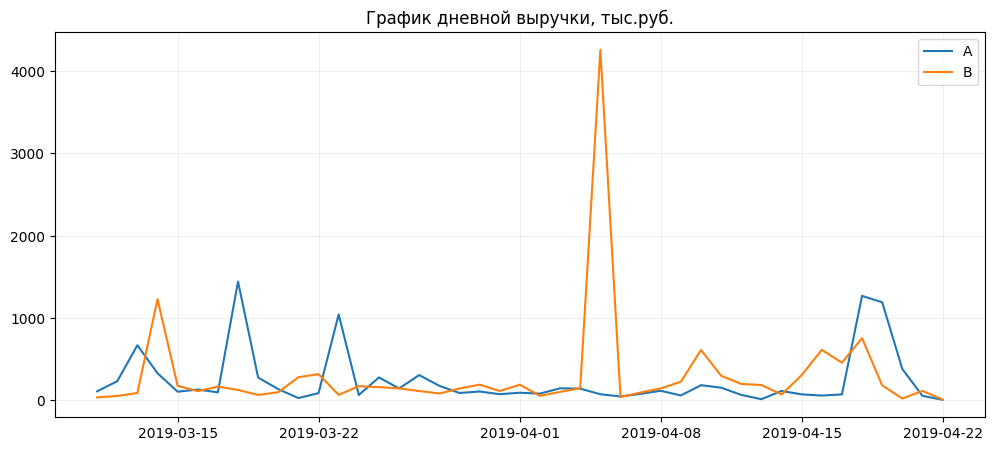

In [57]:
plt.figure(figsize=(12,5))
plt.plot(rev_day_A['date'], rev_day_A['revenue']/1000, label = 'A')
plt.plot(rev_day_B['date'], rev_day_B['revenue']/1000, label = 'B')
plt.legend()
plt.grid(alpha = 0.2)
plt.title('График дневной выручки, тыс.руб.')

Вывод: сильные колебания на графике дневной выручки не позволяют сделать вывод о преимуществе какой-либо группы.

In [63]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'userId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [64]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [69]:
cumulativeData=ordersAggregated.merge(visitorsAggregated, left_on=['date','group'], right_on=['date','group'])
cumulativeData.columns=['date','group','orders','buyers','revenue','visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-03-11,A,10,10,110291,321
1,2019-03-11,B,9,9,36646,337
2,2019-03-12,A,35,33,343089,1152
3,2019-03-12,B,35,33,90491,1198
4,2019-03-13,A,59,56,1012663,1852


Text(0.5, 1.0, 'Выручка накопленным итогом, руб.')

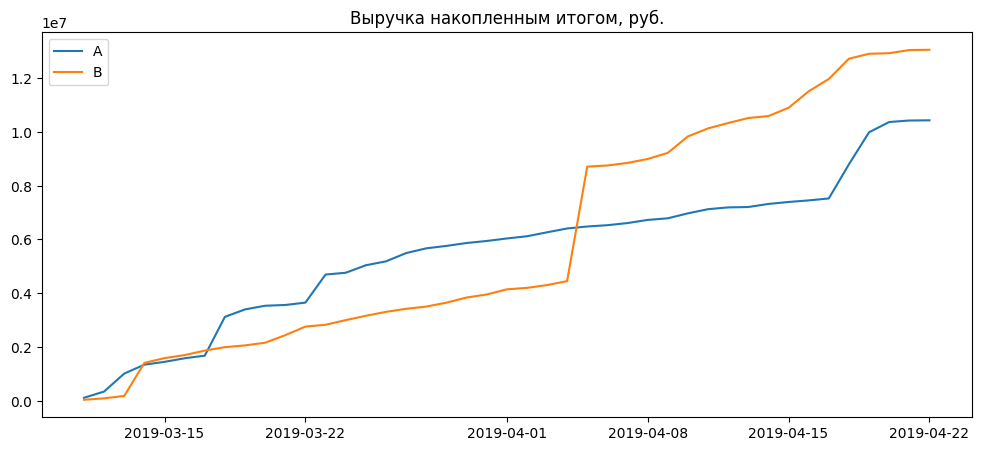

In [74]:
cum_rev_A = cumulativeData.query('group == "A"')
cum_rev_B = cumulativeData.query('group == "B"')

plt.figure(figsize=(12,5))
plt.plot(cum_rev_A['date'],cum_rev_A['revenue'], label = 'A' )
plt.plot(cum_rev_B['date'],cum_rev_B['revenue'], label = 'B' )
plt.legend()
plt.title('Выручка накопленным итогом, руб.')

Вывод: группа В лидирует всю вторую половину теста. Необходима проверка на сверхвысокие покупки в середине теста.

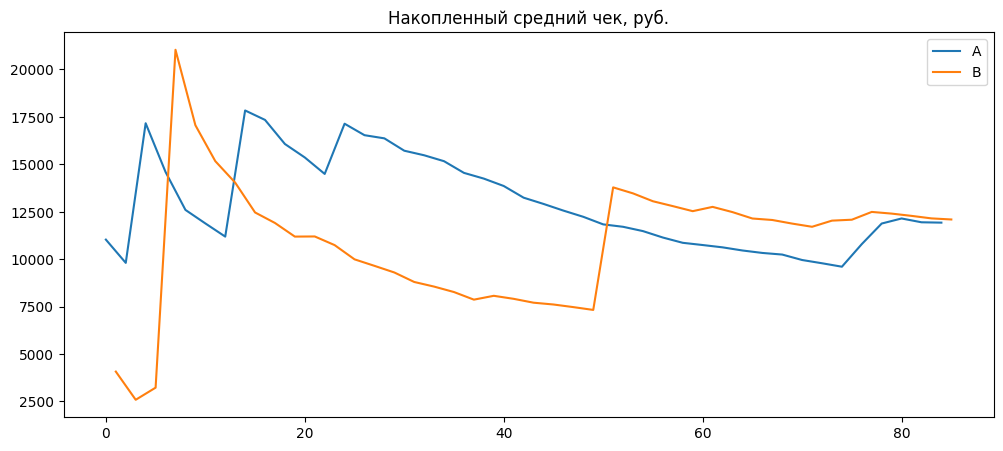

In [80]:
plt.figure(figsize = (12,5))
plt.plot(cum_rev_A['revenue']/cum_rev_A['orders'], label= 'A')
plt.plot(cum_rev_B['revenue']/cum_rev_B['orders'], label = 'B')
plt.title('Накопленный средний чек, руб.')
plt.legend()

Text(0.5, 1.0, 'Изменение относительного накопленного среднего чека')

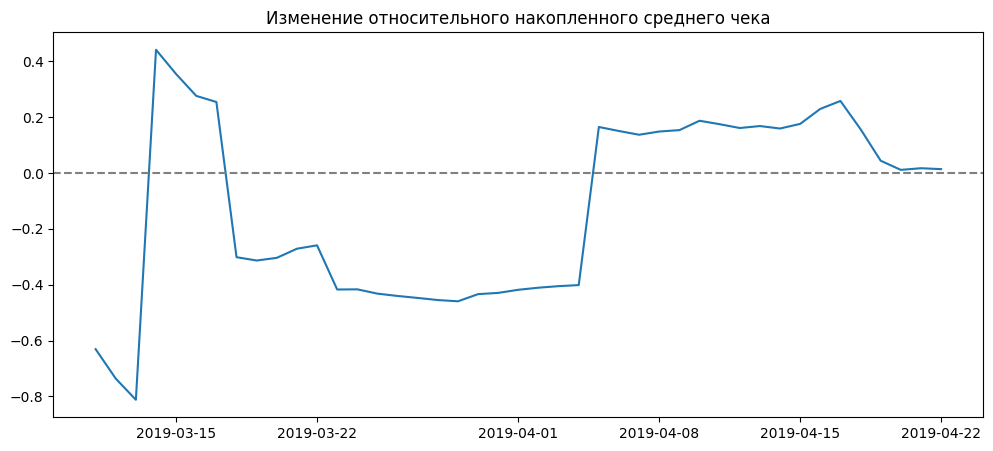

In [85]:
mergedCumulativeRevenue = cum_rev_A.merge(cum_rev_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'] )
plt.figure(figsize = (12,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color = 'gray', linestyle = '--')
plt.title('Изменение относительного накопленного среднего чека')

Вывод: вероятно, аномальные заказы были совершены в даты пересечения оси Х.

In [88]:
cum_rev_A['conv']=cum_rev_A['orders']/cum_rev_A['visitors']
cum_rev_B['conv']=cum_rev_B['orders']/cum_rev_B['visitors']

C:\Users\admin\AppData\Local\Temp\ipykernel_11848\3836681423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cum_rev_A['conv']=cum_rev_A['orders']/cum_rev_A['visitors']
C:\Users\admin\AppData\Local\Temp\ipykernel_11848\3836681423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cum_rev_B['conv']=cum_rev_B['orders']/cum_rev_B['visitors']


Text(0.5, 1.0, 'Накопленная коверсия')

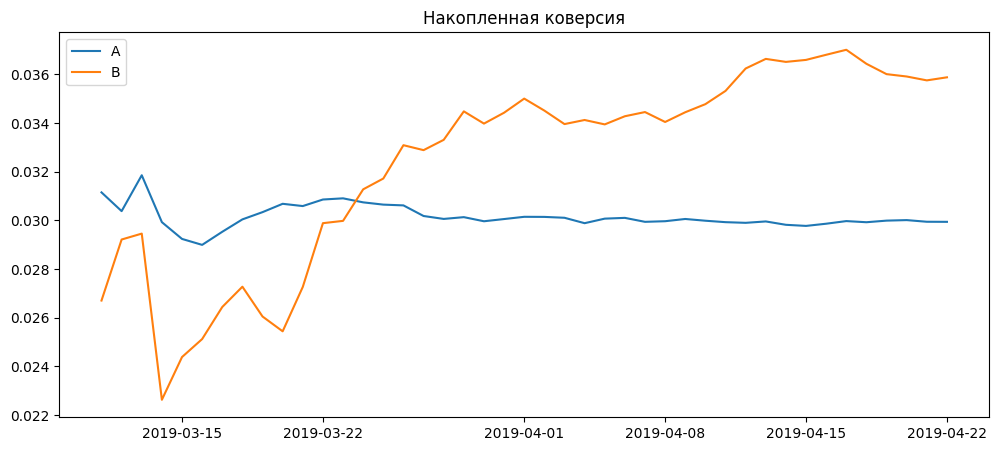

In [97]:
plt.figure(figsize = (12,5))
plt.plot(cum_rev_A['date'], cum_rev_A['conv'], label='A')
plt.plot(cum_rev_B['date'], cum_rev_B['conv'], label='B')
plt.legend()
plt.title('Накопленная коверсия')

Конверсия группы В установилась на уровне выше, чем группы А

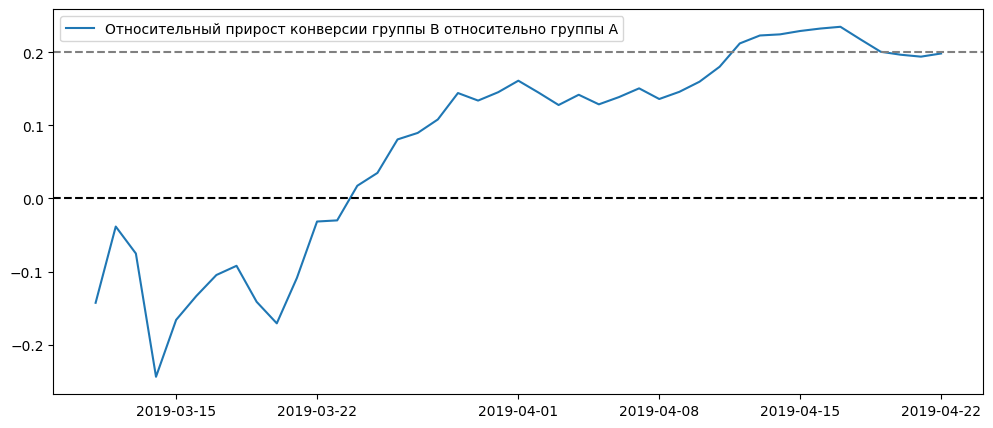

In [199]:
mergedCumulativeConversions = cum_rev_A[['date','conv']].merge(cum_rev_B[['date','conv']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['convB']/mergedCumulativeConversions['convA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

Вывод: группа В стабильно улучшает показатели и стабилизируется на уровне 20%.

<a id="anomal"></a>
**Выявление аномалий**

In [103]:
print(orders['revenue'].max())
print(orders['revenue'].mean())

1955100
4032.1943014074836


(array([5.811e+03, 6.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([1.50000000e+01, 2.44400625e+05, 4.88786250e+05, 7.33171875e+05,
        9.77557500e+05, 1.22194312e+06, 1.46632875e+06, 1.71071438e+06,
        1.95510000e+06]),
 <BarContainer object of 8 artists>)

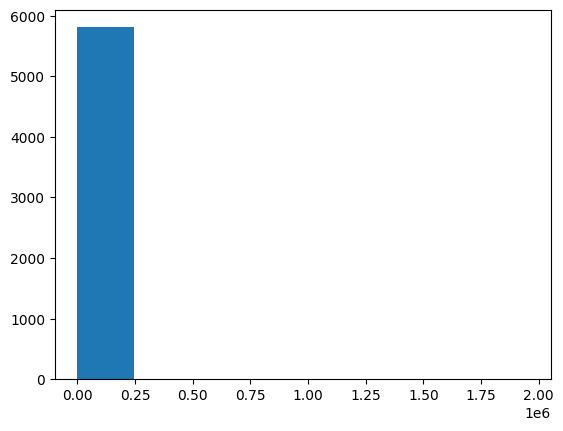

In [129]:
plt.hist(orders['revenue'], bins=8)

Вывод: выручка от большинства заказов не превышает 250 тыс. руб. Распределение стоимости заказов не нормальное.

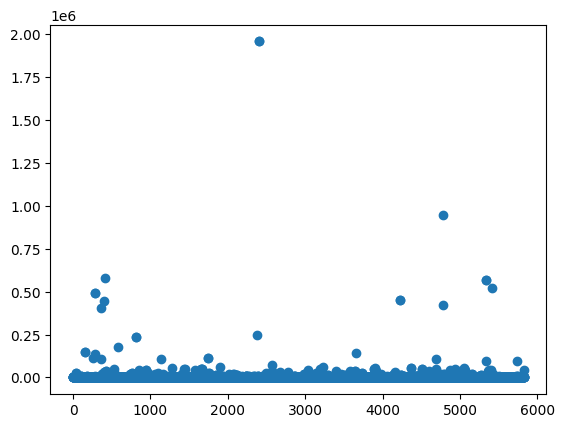

In [107]:
x_value = pd.Series(range(0,(len(orders['revenue']))))
plt.scatter(x_value, orders['revenue'])

Вывод: есть несколько аномально дорогих заказов.

In [109]:
orders['revenue'].describe()

count    5.826000e+03
mean     4.032194e+03
std      4.476075e+04
min      1.500000e+01
25%      2.090000e+02
50%      5.905000e+02
75%      1.599000e+03
max      1.955100e+06
Name: revenue, dtype: float64

In [130]:
print(np.percentile(orders['revenue'], [90, 95,99]))

[ 3937.    7728.25 43535.25]


Не более 1% заказов имеют стоимость более 43,5 тыс. руб.

In [138]:
ordersByUsers=orders.groupby(by = 'userId', as_index = False).agg({'orderId':pd.Series.nunique, 'group':'max'})
print(ordersByUsers.sort_values(by = 'orderId', ascending = False).head())

            userId  orderId group
1571  1.724475e+19       13     A
1085  1.172579e+19       10     A
122   1.216361e+18       10     B
567   6.234396e+18        7     A
1227  1.323237e+19        6     B


(array([1.534e+03, 1.290e+02, 2.000e+01, 6.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 12 artists>)

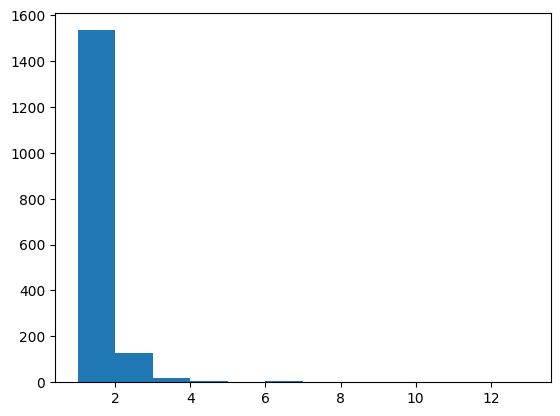

In [123]:
plt.hist(ordersByUsers['orderId'], bins = 12)

Вывод: большинство пользователей сделали один заказ, но есть единичные пользователи, которые сделали до 12 заказов.

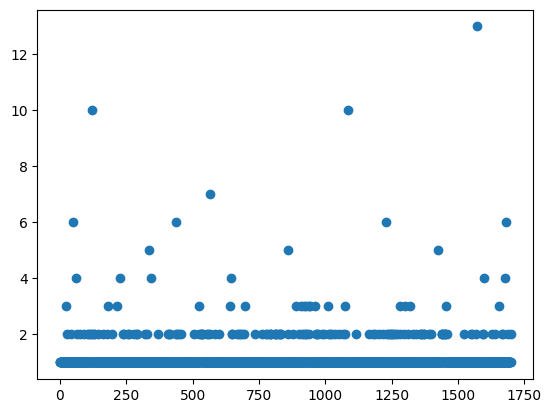

In [124]:
x_values = pd.Series(range(0, len(ordersByUsers['orderId'])))
plt.scatter(x_values, ordersByUsers['orderId'])

In [125]:
print(np.percentile(ordersByUsers['orderId'], [90,95,99]))

[1.   2.   3.01]


In [150]:
ordersByUsersA=ordersByUsers.query('group == "A"').drop(columns = 'group')
ordersByUsersA.columns = ['userId','orders']
ordersByUsersB=ordersByUsers.query('group == "B"').drop(columns = 'group')
ordersByUsersB.columns = ['userId','orders']
ordersByUsersB.head()

,userId,orders
0,4.246030e+15,1
2,4.505278e+16,1
3,4.625652e+16,1
6,6.885552e+16,1
7,7.216641e+16,1


<a id="raw_data_analysis"></a>
**Анализ на "сырых" данных:**

In [204]:
zero_purch_userA = visitors.query('group == "A"')['visitors'].sum() - len(ordersByUsersA) # количество посетителей группы А, не совершивших покупку
zero_purch_userB = visitors.query('group == "B"')['visitors'].sum() - len(ordersByUsersB)# количество посетителей группы В, не совершивших покупку
print(zero_purch_userA,zero_purch_userB)

28462 29159


In [161]:
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0,index = np.arange(zero_purch_userA), name = 'orders')], axis = 0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0,index = np.arange(zero_purch_userB), name = 'orders')], axis = 0)

Нулевая гипотеза: группы А и В не имеют статиститчески значимых различий в конверсии.
Уровень статистической значимости принимаем равным 5%.
Применяем тест Манна-Уитни.

In [165]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.00017
0.198


Первое значение - p-value - ниже 5%, значит нулевую гипотезу отвергаем. Конверсия рассматриваемых групп имеет статистически значимое различие. Относительная разница конверсий составляет 19,8% в пользу группы В

Нулевая гипотеза: группы А и В не имеют статиститчески значимых различий в среднем чеке.
Уровень статистической значимости принимаем равным 5%.
Применяем тест Манна-Уитни.

In [168]:
print("{0:.3f}".format(stats.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]))
print("{0:.3f}".format(orders.query('group == "B"')['revenue'].mean()/orders.query('group == "A"')['revenue'].mean() - 1))

0.211
0.025


Вывод: p-value больше 5%, значит группы не имеют статистически значимых отличий. Кроме того, относительное отличие среднего чека между сегметами составляет всего 2,5%

<a id="anomal_drop"></a>
**Удаление аномальных данных**\
В качестве аномальных примем пользователей, соответствующих следующим критериям:
1. количество заказов 3 и более (1% пользователей),
2. сумма заказа более 10 тыс. руб. (от 1 до 5% пользователей).

In [176]:
usersWithManyOrders=ordersByUsers.query('orderId>=3')['userId'] 
usersWithExpensiveOrders = orders.query('revenue>10000')['userId']
abnormalUsers=pd.concat([usersWithManyOrders,usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

2988    4.246030e+15
3749    1.424692e+17
24      2.374281e+17
1163    3.539876e+17
48      4.867316e+17
Name: userId, dtype: float64
(159,)


Удаление аномальных пользователей:

In [186]:
sampleAfiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index = np.arange(zero_purch_userA), name = 'orders')], axis = 0)
sampleBfiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index = np.arange(zero_purch_userB), name = 'orders')], axis = 0)

<a id="pured_analysis"></a>
**Анализ на очищенных данных**

In [189]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAfiltered, sampleBfiltered)[1]))
print('{0:.3f}'.format(sampleBfiltered.mean()/sampleAfiltered.mean()-1)) 

0.00042
0.188


На очищенных данных выводы сохранились. Статистическая значимость достигнута (p-value меньше 5%).ОТносительное увеличение конверсии в группе В составляет 18,8%

Анализ среднего чека на очищенных данных:

In [192]:
print('{0:.3f}'.format(stats.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['userId'].isin(abnormalUsers)),)]['revenue'], orders[np.logical_and(
                    orders['group'] == 'B',np.logical_not(orders['userId'].isin(abnormalUsers)),)]['revenue'],)[1]))

print("{0:.3f}".format(orders[np.logical_and(
                orders['group'] == 'B',np.logical_not(orders['userId'].isin(abnormalUsers)),)]['revenue'].mean()/ orders[np.logical_and(
                orders['group'] == 'A',np.logical_not(orders['userId'].isin(abnormalUsers)),)]['revenue'].mean()- 1)) 

0.021
0.013


Статистическая значимость достигнута (p-value меньше 5%).Относительное различие среднего чека составляет 1,3%.

<a id="inference"></a>
**Выводы**\
1.Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.\2.
По сырым данным нет статистически значимого различия по среднему чеку между группами. Однако после удаления аномалий статистически значимое различие есть\.3.
График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значени\
** Т тест необходимо признать успешным и заверши. **ть